# How to crawling? - Naver Real Estate Map

In [5]:
#import custom module
import nre.con as nc
import nre.util as nu
from IPython.display import clear_output 
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

sns.set(rc={'figure.figsize':(11.7,8.27)})

nu.IS_LOGGING = False

## 위치을 이용하여 구역 특정

In [6]:
#loc = nc.NLocation(35.18213, 128.1366) # 진주 충무공동
loc = nc.NLocation(37.49911, 127.065463) # 강남 대치동

#https://new.land.naver.com/complexes?ms=37.49911,127.065463,16&a=APT:OPST&b=B1:A1&e=RETAIL&s=EE

cur_region = nc.NRegion('', loc, '0000000000')

# 검색해서 지역 찾기
while True:
    regions = nu.get_region_list(cur_region.no)
    if len(regions) == 0: break
    for i, region in enumerate(regions): 
        print(i, region)
        
    idx = int(input("원하는 도시 인덱스(exit -1) : "))
    clear_output()
    if idx == -1: break
    cur_region = regions[idx]

In [7]:
sector = nu.get_sector(cur_region.loc)
print(sector)

서울시 강남구 논현동 1168010800 loc(37.513583 | 127.031375)


## 매물 조건 생성

In [8]:
addon = nc.NAddon(
    #direction=nc.NAddon.DIR_EACH, #전 방향 탐색의 경우 사용 - 아래 로직을 바꾸세요
    tradeType=[nc.NAddon.TRADE_DEAL, nc.NAddon.TRADE_LEASE], #목표 거래 - 매매, 전세
    estateType=[nc.NAddon.ESTATE_APT, nc.NAddon.ESTATE_OPST] #목표 매물 - 아파트, 오피스텔
)

## 조건과 구역을 이용하여 매물 탐색

In [9]:
things = [] # 매물
removed = 0
for dirr in nc.NAddon.DIR_EACH: # 모든 방향 (남향 등등)
    addon.dir = dirr # 방향 조건 선택
    things.extend(nu.get_things(sector, addon)) # 매물 저장
print('매물 수', len(things))

매물 수 167


## 구역 주변 편의 시설 탐색

In [10]:
neighbors = [] # 편의시설 기록
for nType in nc.NNeighbor.EACH: # 모든 편의시설
    values = nu.get_neighborhood(sector, nType)
    neighbors.extend(values)
    print(nType, len(values))
print('Total', len(neighbors))

BUS 38
METRO 5
INFANT 9
PRESCHOOL 5
SCHOOLPOI 8
HOSPITAL 0
PARKING 94
MART 6
CONVENIENCE 118
WASHING 56
BANK 30
OFFICE 5
Total 374


# 편의시설과 매물 간의 거리 탐색

In [13]:
# 500 == 걸어서 5~10분 이내, 버스로 1분
# 1000 == 버스로 1~2분 

standard = nu.get_distance_standard() # 거리 기준

for (key, value) in standard.items():
    print(key, value, 'm')

nu.update_things_intersection(things, neighbors, standard)

BUS 500 m
METRO 500 m
INFANT 750 m
PRESCHOOL 750 m
SCHOOLPOI 1000 m
HOSPITAL 2000 m
PARKING 500 m
MART 500 m
CONVENIENCE 300 m
WASHING 500 m
BANK 1000 m
OFFICE 2000 m


## 시각화

Dusts 541
APT	(0, 255, 0)
ABYG	(0, 255, 0)
OPST	(255, 0, 0)
OBYG	(255, 0, 0)
JGB	(0, 0, 255)
JGC	(0, 0, 255)
BUS	(0, 255, 255)
METRO	(0, 255, 255)
INFANT	(255, 255, 0)
PRESCHOOL	(255, 255, 0)
SCHOOLPOI	(255, 0, 255)
HOSPITAL	(0, 0, 0)
PARKING	(0, 0, 0)
MART	(0, 0, 0)
CONVENIENCE	(0, 0, 0)
WASHING	(0, 0, 0)
BANK	(0, 0, 0)
OFFICE	(0, 0, 0)


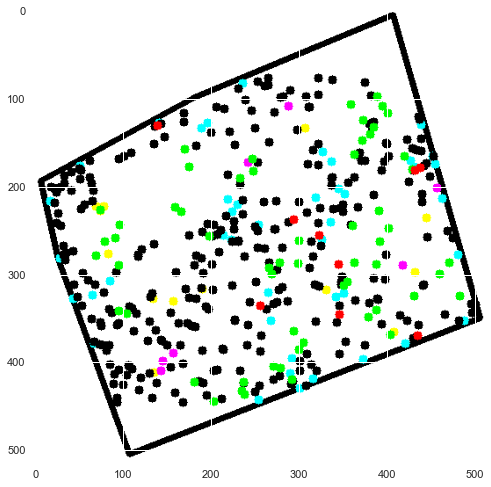

In [15]:
dm = sector.map.get_dimension()

dusts = nu.neighbors_to_dusts(neighbors, dm) # lat, lon -> 좌표 축소
dusts.extend(nu.things_to_dusts(things, dm)) # lat, lon -> 좌표 축소

color_tag = nc.NDimension.get_default_tag_color() # tag에 컬러를 연결

print('Dusts', len(dusts))
for key,value in color_tag.items():
    print(key, value, sep='\t')

plt.imshow(cv2.rotate(dm.get_img(dusts, color_tag), cv2.ROTATE_90_COUNTERCLOCKWISE)) # 출력

## Dataframe

In [16]:
import pandas as pd

def old_classifier(x): #old 구분
    value = abs(int(x[0:4]) - 2022)
    if value <= 5:
        return 'New'
    elif value <= 10:
        return 'Common'
    return 'Old'

In [17]:
total_df = pd.DataFrame(data=[t.get_list() for t in things], columns=nc.NThing.HEADER)
total_df['Old'] = total_df['Build'].apply(old_classifier)
total_df['sector'] = sector.name

total_df

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE,Old,sector
0,아나하(도시형),APT,202006,EE,36.48,93.56,36.0,149,225000.0,240000.0,...,5,0,26,1,8,15,20,5,New,논현동
1,동광팰리스(도시형),APT,201605,EE,30.99,40.3,34.0,194,47000.0,76000.0,...,5,0,17,0,7,7,15,5,Common,논현동
2,한양수자인어반게이트(도시형),APT,201306,EE,23.42,29.92,23.0,249,21100.0,25500.0,...,7,0,20,0,17,21,22,5,Common,논현동
3,우민,APT,200208,EE,99.54,99.54,99.0,269,130000.0,137000.0,...,5,0,24,0,13,8,19,5,Old,논현동
4,논현e-편한세상,APT,200507,EE,109.11,166.25,109.0,249,170000.0,230000.0,...,3,0,13,1,9,19,15,5,Old,논현동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,세양에이팩스타워,OPST,200308,NN,48.89,60.96,48.0,880,30000.0,32000.0,...,2,0,8,1,6,7,22,5,Old,논현동
163,강남파라곤,OPST,200701,WN,103.45,160.7,142.0,789,109000.0,195000.0,...,5,0,18,1,14,7,18,5,Old,논현동
164,마일스디오빌(주상복합),APT,200411,WN,47.19,47.19,47.0,599,38000.0,43000.0,...,7,0,22,1,11,17,27,5,Old,논현동
165,펜트힐루논현,OPST,202108,WN,120.73,189.22,120.0,479,155000.0,300000.0,...,8,0,28,2,10,10,21,5,New,논현동


In [18]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                167 non-null    object 
 1   Type                167 non-null    object 
 2   Build               167 non-null    object 
 3   Dir                 167 non-null    object 
 4   minArea             167 non-null    object 
 5   maxArea             167 non-null    object 
 6   representativeArea  167 non-null    float64
 7   floorAreaRatio      167 non-null    int64  
 8   minDeal             156 non-null    float64
 9   maxDeal             156 non-null    float64
 10  medianDeal          156 non-null    float64
 11  minLease            137 non-null    float64
 12  maxLease            137 non-null    float64
 13  medianLease         126 non-null    float64
 14  minDealUnit         156 non-null    float64
 15  maxDealUnit         156 non-null    float64
 16  medianDe

In [21]:
total_df.describe()

,representativeArea,floorAreaRatio,minDeal,maxDeal,medianDeal,minLease,maxLease,medianLease,minDealUnit,maxDealUnit,...,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,167.000000,167.000000,156.000000,156.000000,156.000000,137.000000,137.000000,126.000000,156.000000,156.000000,...,167.000000,167.000000,167.000000,167.0,167.000000,167.000000,167.000000,167.00000,167.000000,167.0
mean,108.389222,333.874251,147379.487179,196634.615385,156294.871795,78105.839416,102208.759124,83773.809524,4313.769231,5568.057692,...,3.928144,1.964072,5.574850,0.0,19.820359,0.934132,10.628743,12.42515,19.257485,5.0
std,64.337855,192.585802,93392.898617,144689.894715,96996.040355,36233.030037,55678.736403,43451.146229,1429.760900,3277.120916,...,1.282735,0.805794,1.557752,0.0,7.178705,0.769429,2.547125,4.73440,3.272676,0.0
min,21.000000,0.000000,17500.000000,17500.000000,17500.000000,20000.000000,20000.000000,20000.000000,1356.000000,1552.000000,...,2.000000,0.000000,2.000000,0.0,2.000000,0.000000,6.000000,5.00000,11.000000,5.0
25%,69.000000,236.000000,92000.000000,105000.000000,95000.000000,50000.000000,70000.000000,53750.000000,3486.000000,3819.000000,...,3.000000,2.000000,5.000000,0.0,14.000000,0.000000,9.000000,8.00000,17.000000,5.0
50%,104.000000,264.000000,140000.000000,179000.000000,150500.000000,80000.000000,95000.000000,80000.000000,4257.000000,4949.500000,...,3.000000,2.000000,5.000000,0.0,20.000000,1.000000,10.000000,12.00000,19.000000,5.0
75%,124.500000,359.000000,185750.000000,250000.000000,190000.000000,95000.000000,130000.000000,91000.000000,5185.250000,5852.000000,...,5.000000,2.000000,7.000000,0.0,26.000000,1.000000,12.000000,17.00000,21.000000,5.0
max,491.000000,1045.000000,600000.000000,900000.000000,600000.000000,240000.000000,300000.000000,240000.000000,7998.000000,22039.000000,...,7.000000,4.000000,8.000000,0.0,37.000000,3.000000,17.000000,25.00000,27.000000,5.0


## 시각화 라벨

In [22]:
target_lbl = 'minLease'

## 방향에 따른 가격

<AxesSubplot:xlabel='Dir', ylabel='minLease'>

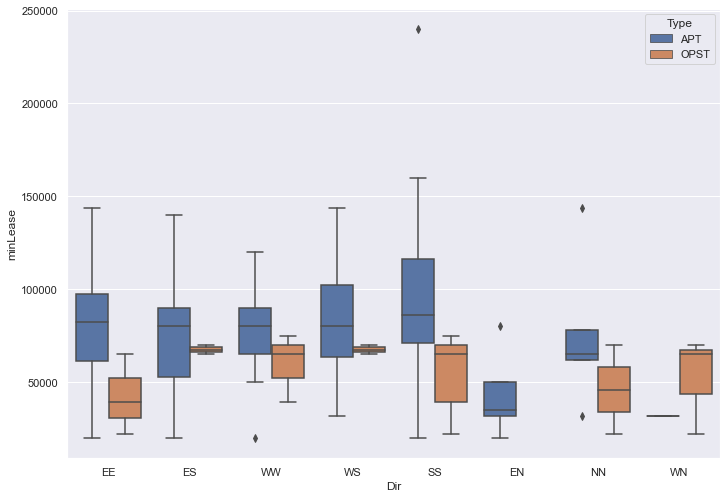

In [23]:
sns.boxplot(x='Dir', y = target_lbl, hue='Type', data=total_df)

## 오피스텔과 아파트 차이

<AxesSubplot:xlabel='Type', ylabel='minLease'>

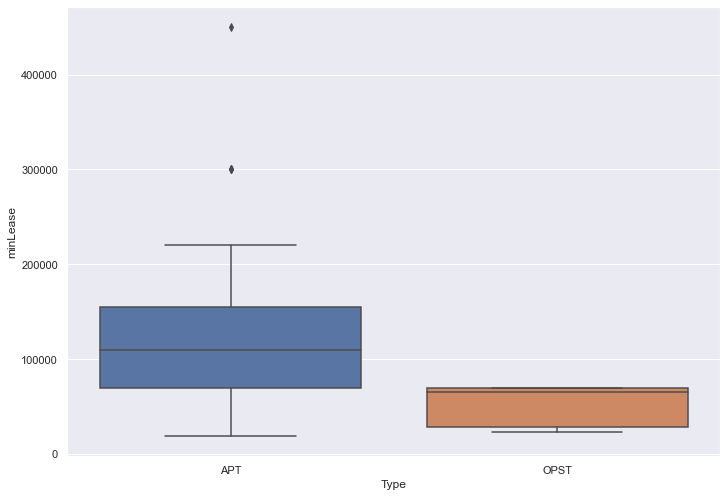

In [28]:
sns.boxplot(x='Type', y = target_lbl, data=total_df)

## 연식에 따른 차이

<AxesSubplot:xlabel='Old', ylabel='minLease'>

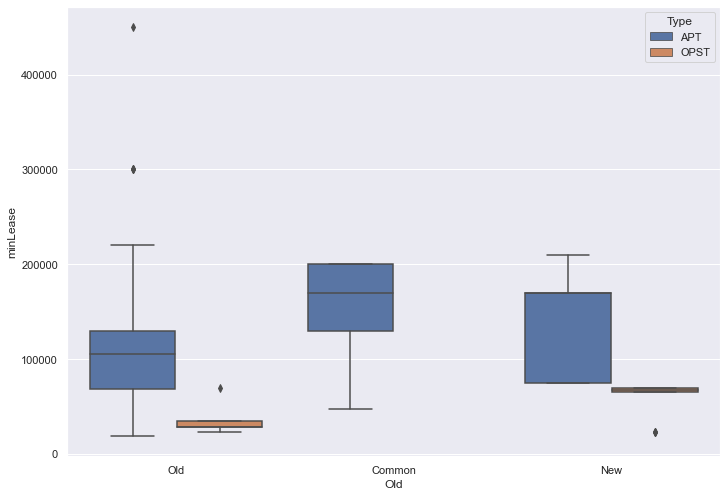

In [29]:
sns.boxplot(x='Old', y = target_lbl, hue='Type', data=total_df)

## 저장

In [21]:
total_df.to_csv('./csv/%s - %s house_price.csv' % (sector.name, sector.city), sep=',', na_rep='NaN', index=False)